# (02) DOVES—PoisMLP—0

**Motivation**: Amort: MLP encoder. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Build model + trainer

In [3]:
cfg_vae, cfg_tr = default_configs('DOVES', model_type, 'mlp+b|lin')

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'DOVES', 'n_ch': 16, 'n_latents': 512, 'prior_clamp': -3.0, 'prior_log_dist': 'uniform', 'rmax_q': 1.0,
'enc_type': 'mlp', 'dec_type': 'lin', 'enc_bias': True, 'dec_bias': False}

Trainer:
{'temp_anneal_portion': 1.0, 'temp_anneal_type': 'exp', 'temp_start': 1.0, 'temp_stop': 0.05, 'lr': 0.005, 
'batch_size': 1000, 'epochs': 3600, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  2.4 Mil   |
|     ---     |    ---     |
|     enc     |  2.1 Mil   |
|    fc_enc   |  131.6 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-3)_rmax(1)_DOVES_z-512_k-16_<mlp+b|lin>
mc_b1000-ep3600-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)_(2024_05_05,08:43)

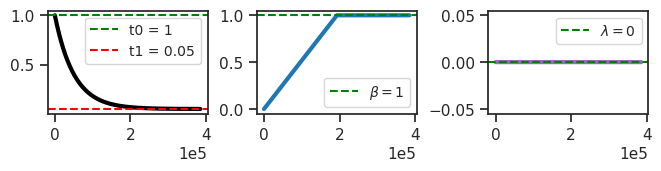

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [5]:
print(vae)

PoissonVAE(
  (mse): MSELoss()
  (enc): ResDenseLayer(
    (fc1): Linear(in_features=256, out_features=4096, bias=True)
    (fc2): Linear(in_features=4096, out_features=256, bias=True)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.1, inplace=False)
    (relu): ReLU()
  )
  (fc_enc): Linear(in_features=256, out_features=512, bias=True)
  (fc_dec): Linear(in_features=512, out_features=256, bias=False)
)

In [6]:
vae.fc_dec.bias, vae.fc_enc.bias.shape

(None, torch.Size([512]))

## Train

In [7]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3600, avg loss: 164.413077: 100%|█████████████████████| 3600/3600 [1:09:20<00:00,  1.16s/it]


In [7]:
## Was: 1800 epochs / batch = 500

epoch # 1800, avg loss: 164.791712: 100%|█████████████████████| 1800/1800 [1:08:21<00:00,  2.28s/it]


In [7]:
## Was: 3600 epochs / batch = 1000

epoch # 3600, avg loss: 164.413077: 100%|█████████████████████| 3600/3600 [3:20:09<00:00,  3.34s/it]


In [7]:
## Was: 1200 epochs / batch = 1000

epoch # 1200, avg loss: 164.852377: 100%|███████████████████████| 1200/1200 [20:23<00:00,  1.02s/it]


epoch # 3600, avg loss: 164.364710: 100%|█████████████████████| 3600/3600 [1:44:51<00:00,  1.75s/it]


## Eval

### Loss vld (freeze)

In [8]:
data, loss, rates = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 134.39989, 'kl': 29.64493, 'kl_diag': 0.05739137, 'tot': 164.04482}

### Identify dead neurons

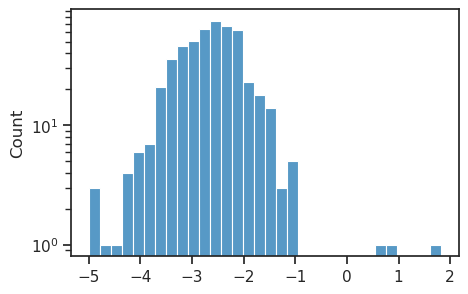

In [9]:
ax = sns.histplot(tonp(vae.log_rate.squeeze()))
ax.set_yscale('log')

In [10]:
dead_thres = 0.01
dead = np.logical_or(
    loss['kl_diag'] < dead_thres,
    tonp(vae.log_rate.squeeze()) > -0.5
)
dead.sum()

7

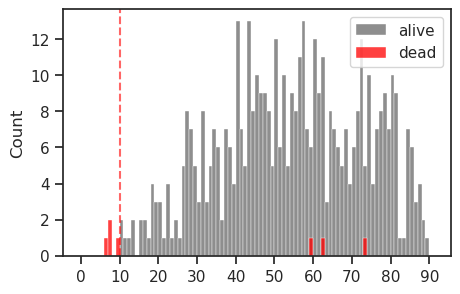

In [11]:
bins = np.linspace(0, 91, 92)
ax = sns.histplot(loss['kl_diag'][~dead] * 1000, bins=bins, color='dimgrey', label='alive')
sns.histplot(loss['kl_diag'][dead] * 1000, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

### Spike counts

In [12]:
lifetime, population, percents = sparse_score(data['z'][:, ~dead], cutoff=0.05)
print(percents)

{'0': 93.1, '1': 6.0, '2': 0.7, '3+': 0.2}

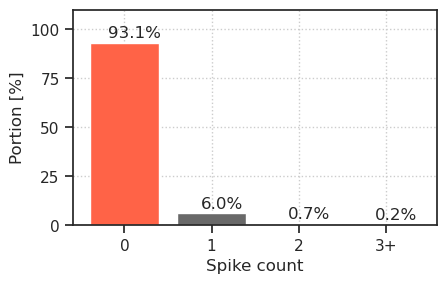

In [13]:
fig, ax = create_figure(1, 1, (4.7, 2.8))

max_val = float(list(percents.values())[0])
ax.set(
    xlabel='Spike count',
    ylabel='Portion [%]',
    ylim=(0, (np.ceil(max_val / 10) + 1) * 10),
)
colors = ['tomato' if lbl == '0' else 'dimgrey' for lbl in percents]
bars = ax.bar(percents.keys(), percents.values(), color=colors)

for bar in bars:
    y = bar.get_height()
    x = bar.get_x() + 1.3 * bar.get_width() / 2
    plt.text(x, y + 1, f'{y:0.1f}%', ha='center', va='bottom')

ax.locator_params(axis='y', nbins=5)

ax.grid()
plt.show()

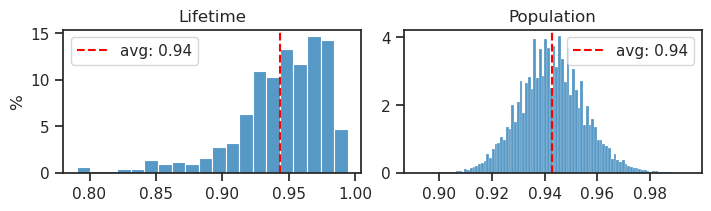

In [14]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(lifetime, stat='percent', ax=axes[0])
sns.histplot(population, stat='percent', ax=axes[1])

for i, x2p in enumerate([lifetime, population]):
    _a, _med = np.nanmean(x2p), np.nanmedian(x2p)
    # axes[i].axvline(_med, color='g', ls='--', label=f'median: {_med:0.2f}')
    axes[i].axvline(_a, color='r', ls='--', label=f'avg: {_a:0.2f}')

add_legend(axes)
axes[0].set(title='Lifetime', ylabel='%')
axes[1].set(title='Population', ylabel='')
plt.show()

In [15]:
tot_nspks = data['z'][:, ~dead].sum(1)
tot_firing = (data['z'][:, ~dead] > 0).mean(1)

min(tot_nspks), max(tot_nspks)

(13.0, 90.0)

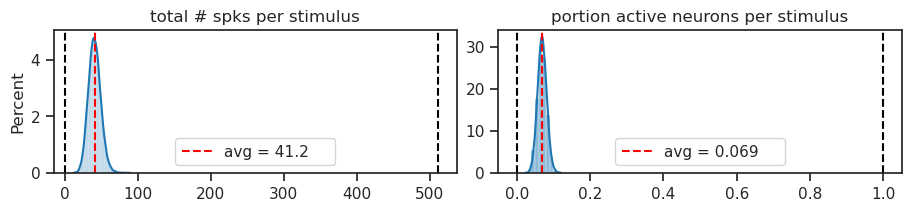

In [16]:
a = np.floor(min(tot_nspks) / 10) * 10
b = np.ceil(max(tot_nspks) / 10) * 10

fig, axes = create_figure(1, 2, (9, 2), layout='constrained')

sns.histplot(tot_nspks, bins=np.linspace(a, b, int(b - a) + 1), kde=True, stat='percent', ax=axes[0])
sns.histplot(tot_firing, bins=np.linspace(0, 1.0, 101), kde=True, stat='percent', ax=axes[1])

_a = tot_nspks.mean()
axes[0].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.1f}    ')
_a = tot_firing.mean()
axes[1].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.3f}    ')

axes[0].axvline(vae.cfg.n_latents, color='k', ls='--')
axes[1].axvline(1.0, color='k', ls='--')

axes[0].set_title('total # spks per stimulus')
axes[1].set(title='portion active neurons per stimulus', ylabel='')

for ax in axes.flat:
    ax.axvline(0, color='k', ls='--')
    ax.legend()
plt.show()

### Cosine sim enc/dec

In [17]:
with torch.inference_mode():
    w_dec = tr.model.fc_dec.weight.detach().data
    w_enc = tr.model.fc_enc.weight.detach().data

    w_dec = w_dec[:, ~dead]
    w_enc = w_enc[~dead]

    cos_sim = F.cosine_similarity(w_dec.T, w_enc)
    slope = torch.einsum('ic, ci -> c', w_dec, w_enc)
    slope /= torch.norm(w_enc, dim=1).pow(2)

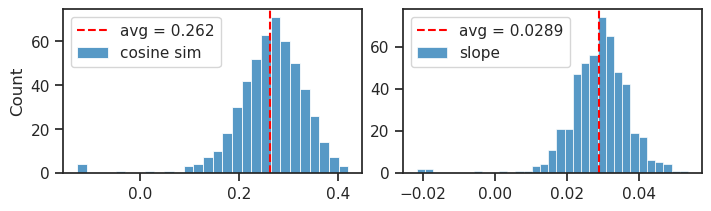

In [18]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(tonp(cos_sim), label='cosine sim', ax=axes[0])
sns.histplot(tonp(slope), label='slope', ax=axes[1])

_avg = cos_sim.mean().item()
axes[0].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')
_avg = slope.mean().item()
axes[1].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')

for ax in axes.flat:
    ax.legend()
axes[1].set_ylabel('')
plt.show()

### Plot enc/dec weights

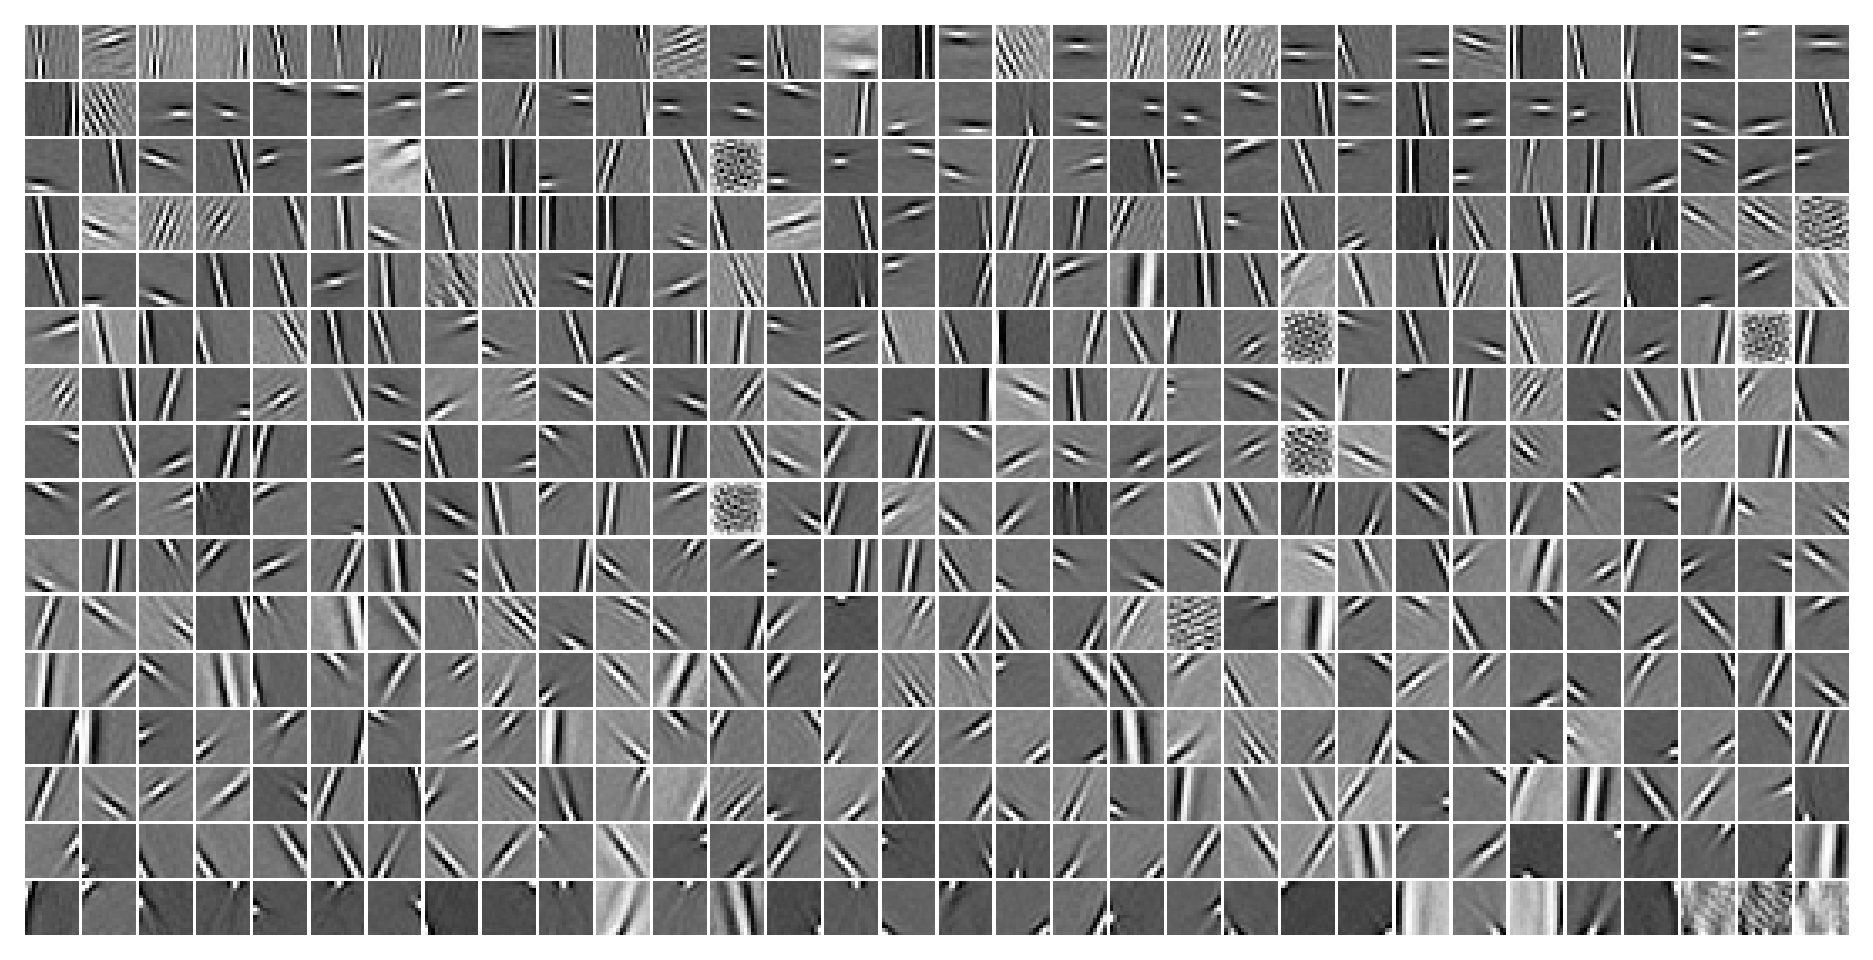

In [19]:
vae.show(dpi=250, order=np.argsort(tonp(vae.log_rate.squeeze())));

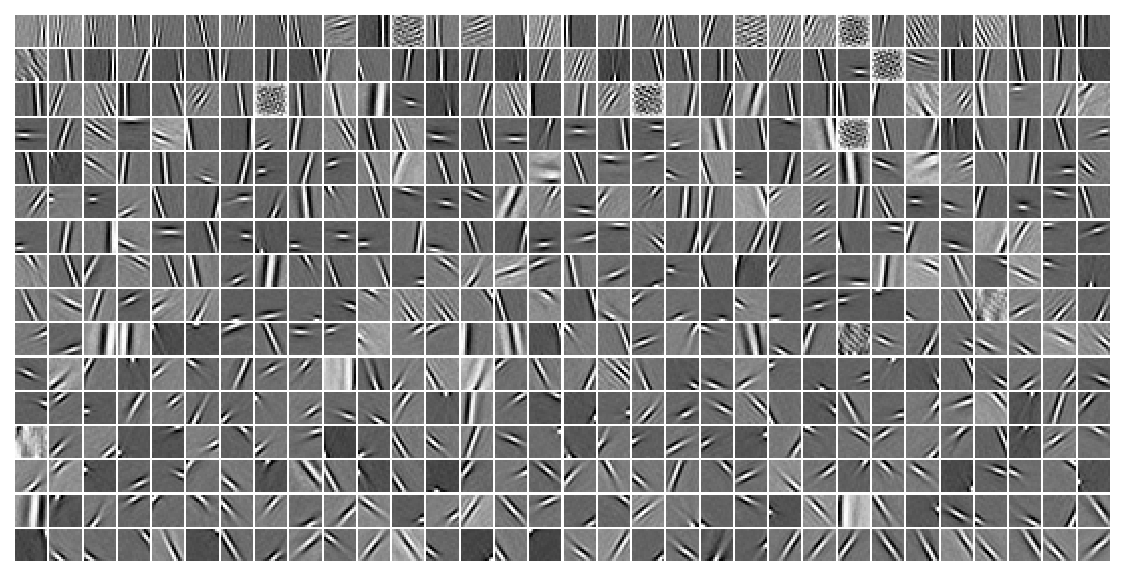

In [20]:
vae.show(dpi=150, order=np.argsort(loss['kl_diag']));

### Some more distributions

In [21]:
prior_rates = tonp(vae.log_rate)[:, ~dead].ravel()

mu, sd = sp_stats.norm.fit(prior_rates)
rv = sp_stats.norm(mu, sd)

xs = np.linspace(
    rv.ppf(1e-6),
    rv.ppf(1 - 1e-6),
    1000,
)
pdf = rv.pdf(xs)

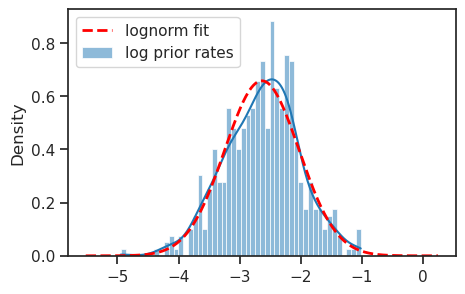

In [22]:
fig, ax = create_figure()

sns.histplot(prior_rates, stat='density', bins=50, kde=True, element='bars', label='log prior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

In [23]:
ks = sp_stats.kstest(
    rvs=prior_rates,
    cdf=rv.cdf,
    alternative='two-sided',
)
print(ks)

KstestResult(statistic=0.035075594465903026, pvalue=0.5514531588602861, statistic_location=-2.5101538, 
statistic_sign=-1)

## Loggabor analysis

In [24]:
from analysis.loggabor import fit_loggabor
from figures.theta import plot_theta
from figures.imgs import plot_weights

In [25]:
results = fit_loggabor(tr, verbose=True)

 87%|█████████▌ | 446/512 [00:16<00:01, 37.12it/s]

 97%|██████████▋| 495/512 [00:18<00:00, 25.19it/s]

100%|███████████| 512/512 [00:18<00:00, 27.72it/s]


In [26]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,r_prior
count,501.000000,501.000000,501.000000,494.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,7.433378,7.439363,0.013156,0.285349,-0.100823,0.603231,0.293187,92.011255,0.085821
std,3.699381,4.185905,0.984917,0.243805,1.096619,0.814751,0.372136,47.983501,0.054899
min,0.357653,0.000000,-1.570796,0.065785,-7.320454,0.069076,0.055431,0.339810,0.007112
25%,4.799791,3.792889,-0.912679,0.228742,-0.669857,0.423645,0.134166,53.056081,0.046908
50%,7.341398,7.599455,-0.018037,0.247853,-0.166980,0.485517,0.211695,90.000079,0.073777
75%,10.240226,11.016710,0.910608,0.281841,0.489320,0.586363,0.314360,129.622320,0.108770
max,14.579519,15.469686,1.570796,3.121440,6.911296,13.152300,5.928021,179.940123,0.361897


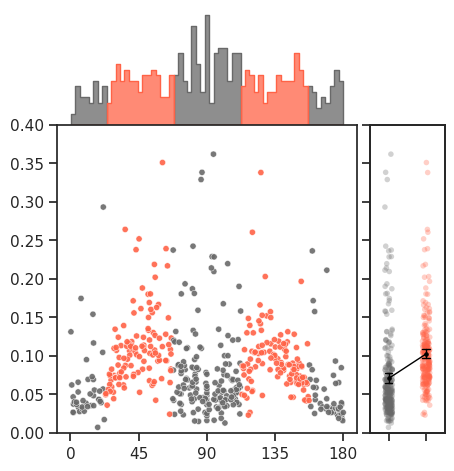

In [29]:
fig, _ = plot_theta(results, ylim=(-0.0, 0.4))

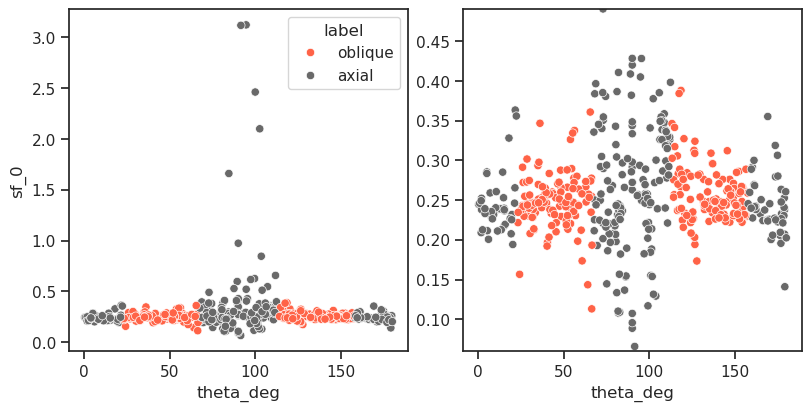

In [30]:
pal = {'axial': 'dimgrey', 'oblique': 'tomato'}

fig, axes = create_figure(1, 2, (8, 4), layout='constrained')
sns.scatterplot(data=results, y='sf_0', x='theta_deg', hue='label', palette=pal, ax=axes[0])
sns.scatterplot(data=results, y='sf_0', x='theta_deg', hue='label', palette=pal, ax=axes[1])
axes[1].set(ylim=(0.06, 0.49), ylabel='')
move_legend(axes[1])
plt.show()

In [31]:
rates_axial = results.loc[(results['label'] == 'axial') & ~dead, 'r_prior'].values
rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, 'r_prior'].values

print(f"{sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')}")

MannwhitneyuResult(statistic=14764.0, pvalue=1.5777977765075965e-24)

In [32]:
a, b = len(rates_axial), len(rates_oblique)
a / (a+b), b / (a+b)

(0.5229540918163673, 0.47704590818363274)

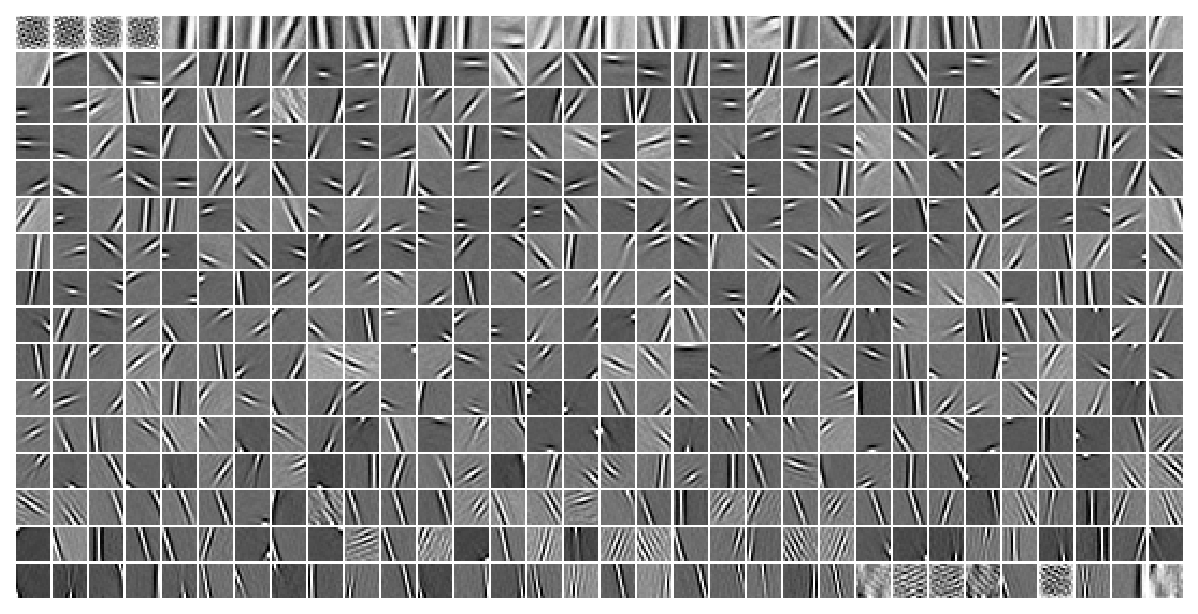

In [33]:
order = np.argsort(results['sf_0'].values)
_ = tr.model.show(order=order)

In [34]:
w_dec = tonp(tr.model.fc_dec.weight.data)
w_dec = w_dec.T.reshape(-1, 16, 16)
ids = np.argsort(results['sf_0'].values)

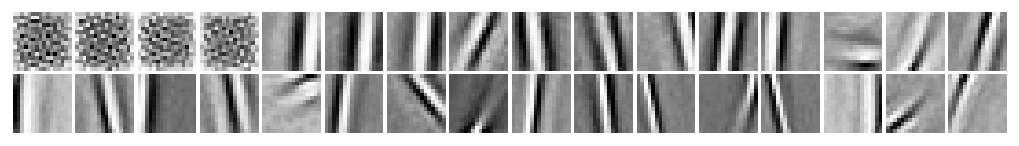

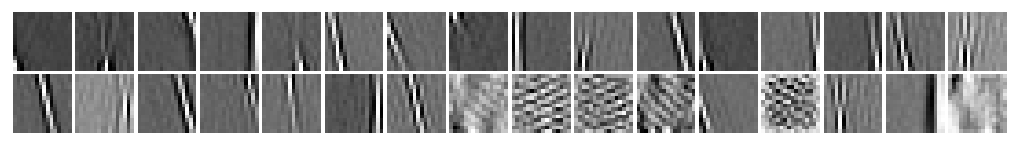

In [35]:
plot_weights(w_dec[ids[:32]], nrows=2, dpi=130)
plt.show()

plot_weights(w_dec[ids[-32:]], nrows=2, dpi=130)
plt.show()